In [1]:
using JuMP, Cbc, Gurobi
using PyPlot

In [4]:
n_workers = 7
n_tasks = 20
quotas = rand(1:10, n_tasks)
horizon = maximum(quotas)
# quotas = [20 30 10 5 3]
# initial_task_lengths = [5 3 7 2 10]
# min_task_lengths = [2 1 2 1 2]
initial_task_lengths = rand(1:10, n_tasks)
min_task_lengths = max.(1, initial_task_lengths - rand(1:10, n_tasks))
# W = repeat(task_lengths, inner=[n_workers, 1]) # workers x initial skill
task_bundle_times = [sum(max(min_task_lengths[j], initial_task_lengths[j]-t) for t in 1:T) for j in 1:n_tasks, T in 1:horizon]

20×10 Array{Int64,2}:
 1   2   3   4   5   6   7   8   9  10
 5   9  12  14  16  18  20  22  24  26
 4   7  10  13  16  19  22  25  28  31
 2   3   4   5   6   7   8   9  10  11
 1   2   3   4   5   6   7   8   9  10
 7  14  21  28  35  42  49  56  63  70
 2   3   4   5   6   7   8   9  10  11
 7  13  18  22  25  28  31  34  37  40
 8  15  21  26  30  33  35  36  37  38
 8  15  21  26  30  33  36  39  42  45
 7  13  18  22  26  30  34  38  42  46
 6  12  18  24  30  36  42  48  54  60
 1   2   3   4   5   6   7   8   9  10
 7  13  18  22  25  27  28  29  30  31
 5   9  12  14  15  16  17  18  19  20
 6  11  15  18  20  22  24  26  28  30
 8  15  21  26  30  33  35  36  37  38
 2   3   4   5   6   7   8   9  10  11
 5   9  12  14  15  16  17  18  19  20
 4   7   9  10  11  12  13  14  15  16

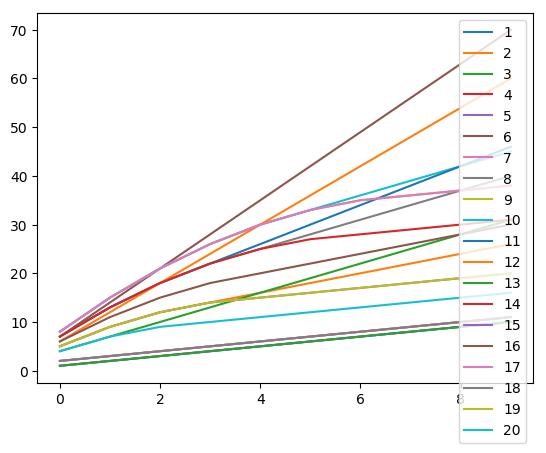

PyObject <matplotlib.legend.Legend object at 0x7f137c650940>

In [5]:
plot(task_bundle_times')
legend(1:n_tasks)

In [6]:
m = Model(solver=GurobiSolver())
@variable(m, work[1:n_workers, 1:n_tasks, 1:horizon], Bin)
@variable(m, slowest_worker >= 0)

@expression(m, work_on[j in 1:n_tasks], sum(work[i,j,t]*t for t in 1:horizon, i in 1:n_workers))

# we must meet quotas
@constraint(m, quota_constr[j in 1:n_tasks], work_on[j] >= quotas[j])

# worker speed
@expression(m, worker_speed[i in 1:n_workers],
    sum(sum(task_bundle_times[j, t] * work[i,j,t] for t in 1:horizon) for j in 1:n_tasks))

for i in 1:n_workers, j in 1:n_tasks
    addSOS1(m, work[i,j,:])
end

# ∞-norm epigraph bounds for slowest_worker
@constraints(m, begin
    worker_speed .<= slowest_worker
    -slowest_worker .<= worker_speed
end)

# minimize the amount of time the slowest worker takes
@objective(m, Min, slowest_worker)

# println(m)
;

In [7]:
@time(solve(m))

Academic license - for non-commercial use only
Optimize a model with 34 rows, 1401 columns and 4214 nonzeros
Model has 140 SOS constraints
Variable types: 1 continuous, 1400 integer (1400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve added 119 rows and 0 columns
Presolve removed 0 rows and 651 columns
Presolve time: 0.01s
Presolved: 153 rows, 750 columns, 2240 nonzeros
Variable types: 0 continuous, 750 integer (749 binary)
Found heuristic solution: objective 91.0000000

Root relaxation: objective 5.357143e+01, 87 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   53.57143    0   11   91.00000   53.57143  41.1%     -    0s
H    0     0                      89.0000000   53.57143  39.8%     -    0s
H    0     0           

:Optimal

In [10]:
assignments = getvalue(work)
for i in 1:n_workers
    for j in 1:n_tasks
        n = findfirst(assignments[i,j,:])
        if n != 0
            println("worker $i performs $j: $n times")
        end
    end
end

worker 1 performs 5: 1 times
worker 1 performs 6: 4 times
worker 1 performs 10: 2 times
worker 1 performs 13: 8 times
worker 1 performs 18: 1 times
worker 2 performs 2: 9 times
worker 2 performs 5: 5 times
worker 2 performs 6: 1 times
worker 2 performs 15: 7 times
worker 3 performs 1: 5 times
worker 3 performs 6: 4 times
worker 3 performs 7: 2 times
worker 3 performs 14: 3 times
worker 4 performs 4: 2 times
worker 4 performs 6: 1 times
worker 4 performs 12: 1 times
worker 4 performs 17: 10 times
worker 5 performs 4: 2 times
worker 5 performs 8: 10 times
worker 5 performs 16: 2 times
worker 6 performs 11: 8 times
worker 6 performs 20: 9 times
worker 7 performs 3: 3 times
worker 7 performs 9: 2 times
worker 7 performs 12: 4 times
worker 7 performs 19: 1 times
